# Final Project - Classification of News Articles using Multinomial Naive Bayes

## Setup

In [27]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
#----------------------------------Text Processing---------------------------------#
import regex
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer
from string import punctuation
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
#---------------------------------------Model---------------------------------------#

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score

from sklearn.naive_bayes import MultinomialNB

## Reading Data

In [2]:
names = []
base = 'data/bbc-fulltext/bbc/'
with os.scandir(base) as entries:
    for entry in entries:
        if(entry.is_file() == False):
            names.append(entry.name)
names

['business', 'entertainment', 'politics', 'sport', 'tech']

In [3]:
files = {}
unique = []
for name in names:
    path = base + name+'/'
    x = []
    with os.scandir(path) as entries:
        for entry in entries:
            if(entry.is_file()):
                x.append(entry.name)
    files[name] = x
    files[name].sort()

In [4]:
for k, v in files.items():
    print(k, len(v))

business 510
entertainment 386
politics 417
sport 511
tech 401


In [5]:
data = {}
i = 0

for genre in files.keys() :
    texts = files[genre]
    for text in texts:
        if text in files[genre]:
            path = base + genre + '/' + text
            with open(path, "r", encoding = "latin1") as file:
                data[i] = file.readlines()
                i = i+1
            data[i-1] = [" ".join(data[i-1]), genre] 

data = pd.DataFrame(data).T
print(data.shape)
data.columns = ['Text', 'Class']
data.head()

(2225, 2)


,Text,Class
0,Ad sales boost Time Warner profit\n \n Quarter...,business
1,Dollar gains on Greenspan speech\n \n The doll...,business
2,Yukos unit buyer faces loan claim\n \n The own...,business
3,High fuel prices hit BA's profits\n \n British...,business
4,Pernod takeover talk lifts Domecq\n \n Shares ...,business


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2225 non-null   object
 1   Class   2225 non-null   object
dtypes: object(2)
memory usage: 52.1+ KB


In [7]:
data.isna().sum()

Text     0
Class    0
dtype: int64

In [8]:
unique = list(data.Text.unique())
len(unique)

# data.Text.duplicated()

2127

### Removing Duplicates

In [9]:
dic = dict(data)

In [10]:
uni = {}
i = 0
for k in range(len(list(dic['Text']))):
    if dic['Text'][k] in unique:
        uni[i] = [dic['Text'][k], dic['Class'][k]]
        unique.remove(dic['Text'][k])
        i += 1

In [11]:
data = pd.DataFrame(uni).T
print(data.shape)
data.columns = ['Text', 'Class']
data.Class.describe()

(2127, 2)


count      2127
unique        5
top       sport
freq        505
Name: Class, dtype: object

In [44]:
print("Number left in business : ", len(data[data.Class == 'business']))
print("Number left in entertainment : ", len(data[data.Class == 'entertainment']))
print("Number left in politics : ", len(data[data.Class == 'politics']))
print("Number left in sport : ", len(data[data.Class == 'sport']))
print("Number left in tech : ", len(data[data.Class == 'tech']))

Number left in business :  503
Number left in entertainment :  369
Number left in politics :  403
Number left in sport :  505
Number left in tech :  347


## Pre-Processing

### Removing Stop Words and Stemming

In [12]:
wordnet_lemmatizer = WordNetLemmatizer()

stop = stopwords.words('english')

for punct in punctuation:
    stop.append(punct)

def filter_text(text, stop_words):
    word_tokens = WordPunctTokenizer().tokenize(text.lower())
    filtered_text = [regex.sub(u'\p{^Latin}', u'', w) for w in word_tokens if w.isalpha() and len(w) > 3]
    filtered_text = [wordnet_lemmatizer.lemmatize(w, pos="v") for w in filtered_text if not w in stop_words] 
    return " ".join(filtered_text)

In [13]:
data["filtered_text"] = data.Text.apply(lambda x : filter_text(x, stop)) 
data.head()

,Text,Class,filtered_text
0,Ad sales boost Time Warner profit\n \n Quarter...,business,sales boost time warner profit quarterly profi...
1,Dollar gains on Greenspan speech\n \n The doll...,business,dollar gain greenspan speech dollar highest le...
2,Yukos unit buyer faces loan claim\n \n The own...,business,yukos unit buyer face loan claim owners embatt...
3,High fuel prices hit BA's profits\n \n British...,business,high fuel price profit british airways blame h...
4,Pernod takeover talk lifts Domecq\n \n Shares ...,business,pernod takeover talk lift domecq share drink f...


### TF-IDF Vector Conversion

In [14]:
tfidf = TfidfVectorizer(lowercase=True)
train_vec = tfidf.fit_transform(data['filtered_text'])
train_vec.shape

(2127, 21613)

In [15]:
data.Class.unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [16]:
data['classification'] = data['Class'].replace(['business','entertainment','politics', 'sport', 'tech'],[0,1,2,3,4])

In [17]:
data

,Text,Class,filtered_text,classification
0,Ad sales boost Time Warner profit\n \n Quarter...,business,sales boost time warner profit quarterly profi...,0
1,Dollar gains on Greenspan speech\n \n The doll...,business,dollar gain greenspan speech dollar highest le...,0
2,Yukos unit buyer faces loan claim\n \n The own...,business,yukos unit buyer face loan claim owners embatt...,0
3,High fuel prices hit BA's profits\n \n British...,business,high fuel price profit british airways blame h...,0
4,Pernod takeover talk lifts Domecq\n \n Shares ...,business,pernod takeover talk lift domecq share drink f...,0
...,...,...,...,...
2122,New consoles promise big problems\n \n Making ...,tech,console promise problems make game future cons...,4
2123,BT program to beat dialler scams\n \n BT is in...,tech,program beat dialler scam introduce initiative...,4
2124,Be careful how you code\n \n A new European di...,tech,careful code european directive could software...,4
2125,US cyber security chief resigns\n \n The man m...,tech,cyber security chief resign make sure computer...,4


In [18]:
train_vec

<2127x21613 sparse matrix of type '<class 'numpy.float64'>'
	with 284268 stored elements in Compressed Sparse Row format>

### Train - Test Split

In [19]:
x_train, x_test, y_train, y_test = train_test_split(train_vec,data['classification'], stratify=data['classification'], test_size=0.2)

In [20]:
x_train

<1701x21613 sparse matrix of type '<class 'numpy.float64'>'
	with 227236 stored elements in Compressed Sparse Row format>

In [21]:
x_test

<426x21613 sparse matrix of type '<class 'numpy.float64'>'
	with 57032 stored elements in Compressed Sparse Row format>

## Training the Model

### Getting the optimized parameters

In [22]:
alpha = np.arange(0, 1, 0.001)
fit_prior = [True, False]

params = {
    'alpha' : alpha,
    'fit_prior' : fit_prior
}

random_search = RandomizedSearchCV(
    estimator = MultinomialNB(),
    param_distributions = params,
    n_iter = 300,
    cv = 5,
    n_jobs = -1,
    random_state = 1,
    verbose = 1
).fit(x_train, y_train)

random_search.best_params_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


{'fit_prior': False, 'alpha': 0.018000000000000002}

<p>After performing 5 fold cross validation for 300 iterations, the best values for the additive laplace smoothing parameter was 0.018 and it was determined better to have a uniform prior</p>

### Model

In [23]:
model_mnb = random_search.best_estimator_
model_mnb.score(x_train, y_train)

0.9976484420928865

In [25]:
y_predicted = model_mnb.predict(x_test)

mnb_acc = accuracy_score(y_test,y_predicted)

print("Accuracy Score : ", mnb_acc)

Accuracy Score :  0.9671361502347418


In [26]:
confusion_matrix(y_test,y_predicted)

array([[ 98,   0,   0,   0,   3],
       [  0,  69,   3,   0,   2],
       [  0,   1,  79,   0,   1],
       [  0,   0,   0, 101,   0],
       [  1,   2,   1,   0,  65]], dtype=int64)

In [34]:
f1_score(y_test, y_predicted, average='weighted')

0.9672141300862307

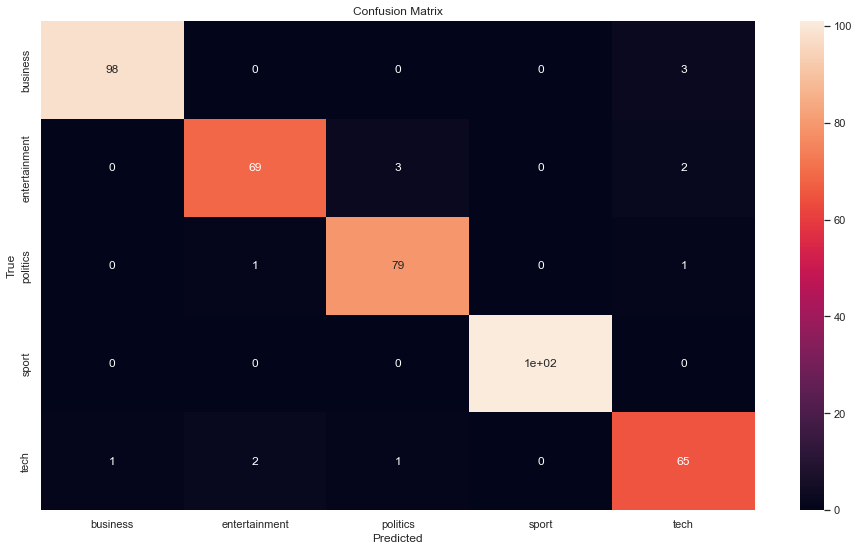

In [37]:
sns.set(rc = {'figure.figsize':(16,9)})
ax = sns.heatmap(confusion_matrix(y_test,y_predicted),annot=True)
ax = ax.set(xlabel='Predicted',ylabel='True',title='Confusion Matrix',
            xticklabels=(['business','entertainment','politics', 'sport', 'tech']),
            yticklabels=(['business','entertainment','politics', 'sport', 'tech']))

## Summary

<p>In this project I have tried to create a model that can categorize news articles into their respective categories. As a sample dataset I have chosen a dataset containing 2225 news articles under the categories of business(510), entertainment(386), politics(417), sport(511) and tech(401). Of the given news articles, after removing duplicates we were left with:
<ul>Number left in business :  503</ul>
<ul>Number left in entertainment :  369</ul>
<ul>Number left in politics :  403</ul>
<ul>Number left in sport :  505</ul>
<ul>Number left in tech :  347</ul>
</p>

<p>Next we work on the words in the preprocessing stage, define a WordNetLemmatizer for stemming and nltk stop word to get rid of regular small worlds used in the english language, additionally adding punctuations to the stop words as well. Then we pass our document texts through the filter function that loops through the text file and returns a file where the words are stemmed, punctuations and stop words are removed and all words are made lower case and are separated by one space and we store this as filtered text. Then we use the TfidfVectorizer to return a sparse matrix depiction of our document. This set of documents contain 21613 unique words. Then we do a 80:20 split for train - test.</p>

<p>In the process to build the model we use the RandomizedCV to perform search to get the optimal parameter setup for our multinomial naive bayes model. In this case we got a value of 0.018 for the laplace smoothing parameter and was recommended to use a uniform prior rather than learn class prior probabilities. Using these parameters to train a model, we got an model with accuracy 96.71% and f-Score of 0.9672. Please look at the graph above for the confusion matrix</p>